**1. Implement a Multi-Layer Perceptron (MLP) Using the Iris Dataset**

In [1]:
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()

In [2]:
print(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import datasets
import numpy as np

X = iris.data  # Feature matrix (4 features)
y = iris.target  # Class labels (0, 1, 2)

print("X matrix :", X.shape)
print("y matrix:", y.shape)

# Step 2: One-hot encode labels
y = y.reshape(-1, 1)  # Reshape to column vector for encoding
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

# Step 3: Split the dataset
# First, split into training (70%) and temporary (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y)

# Further split temp set into validation (10%) and testing (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

# Step 4: Normalize feature values to [0,1] using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform training data
X_val = scaler.transform(X_val)  # Transform validation data
X_test = scaler.transform(X_test)  # Transform test data

# Print dataset shapes
print("\nDataset Splits:")
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")


X matrix : (150, 4)
y matrix: (150,)

Dataset Splits:
Training set: (105, 4), (105, 3)
Validation set: (15, 4), (15, 3)
Testing set: (30, 4), (30, 3)


**2. Define and Train the MLP Model**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoader for batch processing
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(4, 16)  # Input: 4 -> Hidden: 16
        self.output = nn.Linear(16, 3)  # Hidden: 16 -> Output: 3 (softmax)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = torch.softmax(self.output(x), dim=1)  # Softmax for multi-class classification
        return x

# Instantiate model, loss function, and optimizer
model = MLP()
criterion = nn.CrossEntropyLoss()  # Categorical Cross-Entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 50
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            val_outputs = model(batch_X)
            val_loss = criterion(val_outputs, batch_y)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch [1/50], Train Loss: 1.0905, Val Loss: 1.0934
Epoch [2/50], Train Loss: 1.0928, Val Loss: 1.0925
Epoch [3/50], Train Loss: 1.0906, Val Loss: 1.0916
Epoch [4/50], Train Loss: 1.0890, Val Loss: 1.0907
Epoch [5/50], Train Loss: 1.0891, Val Loss: 1.0899
Epoch [6/50], Train Loss: 1.0934, Val Loss: 1.0890
Epoch [7/50], Train Loss: 1.0902, Val Loss: 1.0881
Epoch [8/50], Train Loss: 1.0823, Val Loss: 1.0872
Epoch [9/50], Train Loss: 1.0908, Val Loss: 1.0862
Epoch [10/50], Train Loss: 1.0885, Val Loss: 1.0851
Epoch [11/50], Train Loss: 1.0797, Val Loss: 1.0840
Epoch [12/50], Train Loss: 1.0811, Val Loss: 1.0828
Epoch [13/50], Train Loss: 1.0783, Val Loss: 1.0816
Epoch [14/50], Train Loss: 1.0771, Val Loss: 1.0802
Epoch [15/50], Train Loss: 1.0737, Val Loss: 1.0789
Epoch [16/50], Train Loss: 1.0763, Val Loss: 1.0774
Epoch [17/50], Train Loss: 1.0764, Val Loss: 1.0759
Epoch [18/50], Train Loss: 1.0695, Val Loss: 1.0742
Epoch [19/50], Train Loss: 1.0695, Val Loss: 1.0724
Epoch [20/50], Train 

**3. Evaluate Model Performance**

Accuracy: 0.6667
Precision: 0.5000
Recall: 0.6667
F1-score: 0.5556


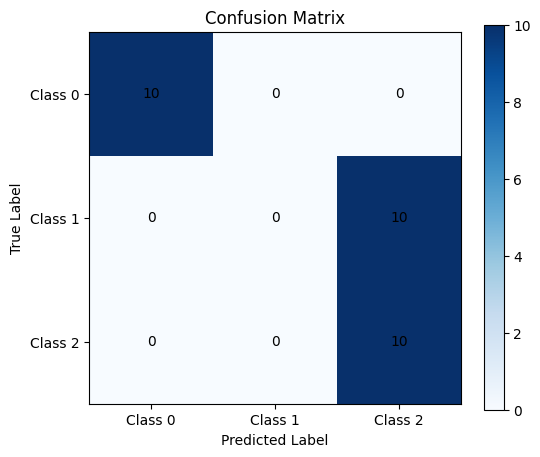

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Model evaluation on test set
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)  # Get probabilities
    y_pred = torch.argmax(y_pred_probs, dim=1).numpy()  # Convert to predicted class labels
    y_true = torch.argmax(y_test_tensor, dim=1).numpy()  # Convert one-hot to labels

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.xticks(np.arange(3), labels=["Class 0", "Class 1", "Class 2"])
plt.yticks(np.arange(3), labels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.grid(False)

# Show numbers inside the confusion matrix
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

plt.show()


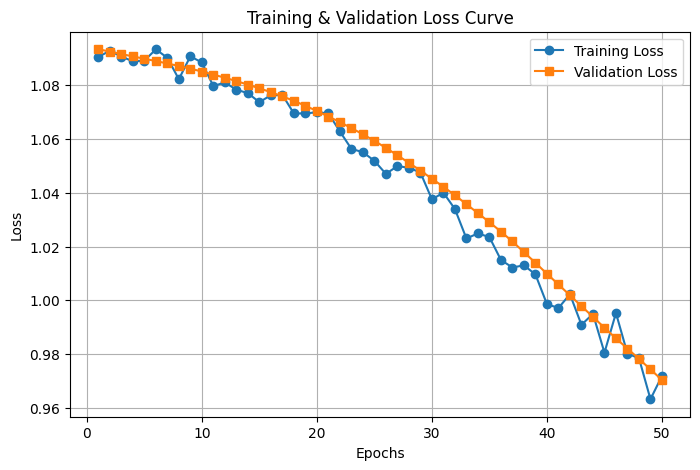

In [6]:
# Plot Training & Validation Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

**4. Set Up Experiment Tracking with Weights & Biases (W&B)**

In [7]:
import wandb

wandb.init(
    project="mlp-next-word-prediction",
    name="MLP-Iris-Classification",
    config={
        "architecture": "MLP",
        "hidden_layers": 1,
        "hidden_neurons": 16,
        "activation": "ReLU",
        "output_neurons": 3,
        "output_activation": "Softmax",
        "optimizer": "Adam",
        "loss_function": "Categorical Crossentropy",
        "learning_rate": 0.001,
        "batch_size": 32,
        "epochs": 50
    }
)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 23110312 (23110312-iit-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [8]:
train_losses_wnb = []
val_losses_wnb = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Compute validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Log losses to W&B
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

wandb.finish()


Epoch [10/50], Training Loss: 0.9321, Validation Loss: 0.9304
Epoch [20/50], Training Loss: 0.8830, Validation Loss: 0.8975
Epoch [30/50], Training Loss: 0.8587, Validation Loss: 0.8733
Epoch [40/50], Training Loss: 0.8325, Validation Loss: 0.8544
Epoch [50/50], Training Loss: 0.8430, Validation Loss: 0.8385


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇█▇▇▇▆▆▇▅▆▆▆▅▅▅▄▅▃▃▄▄▃▂▃▅▂▄▂▂▁▂▁▃▂▂▂▁▁▂
val_loss,███▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,50
train_loss,0.843
val_loss,0.83847


In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Evaluate model on test set
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_logits, dim=1).numpy()
    y_true = y_test_tensor.numpy()

if len(y_true.shape) > 1:  # Check if one-hot encoded
    y_true = np.argmax(y_true, axis=1)

if len(y_pred.shape) > 1:  # Check if one-hot encoded
    y_pred = np.argmax(y_pred, axis=1)
# Compute performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
wandb.init()
# Log final metrics to W&B
wandb.log({
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
})

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 0.7000
Test Precision: 0.8421
Test Recall: 0.7000
Test F1 Score: 0.6238


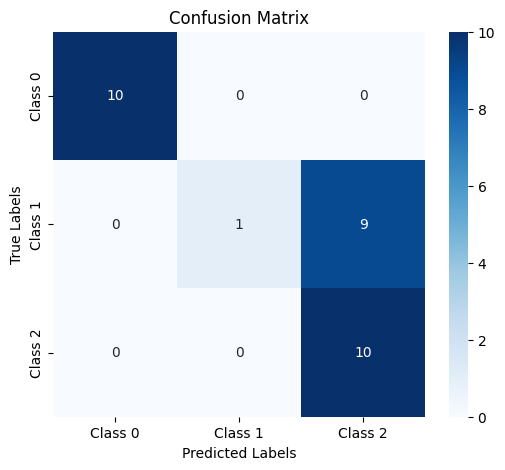

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
wandb.init()
# Save the confusion matrix plot
plt.savefig("confusion_matrix.png")
wandb.log({"confusion_matrix": wandb.Image("confusion_matrix.png")})
plt.show()


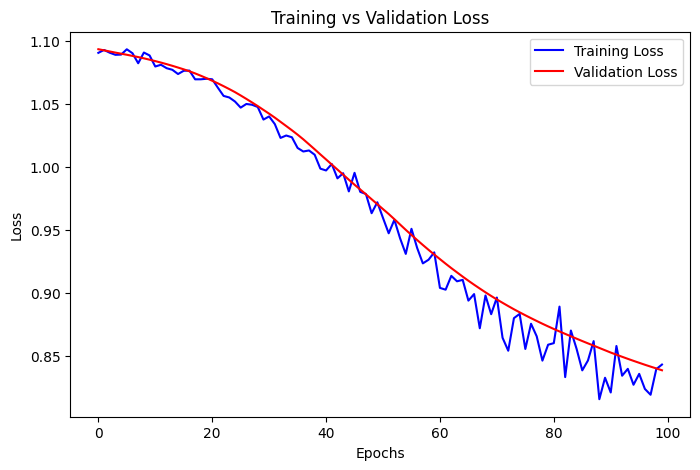

In [11]:
# Plot Training vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
wandb.init()
# Save and log loss curve
plt.savefig("loss_curve.png")
wandb.log({"loss_curve": wandb.Image("loss_curve.png")})
plt.show()
